# Compare classification training of Keras model to TF model

0. Common

In [ ]:
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

encoder = keras.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=16)
], name='encoder')

classifier = keras.Sequential([
    keras.layers.Input(shape=(16)),
    keras.layers.Dense(10, activation='softmax')
])

1. Keras

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.9779 - accuracy: 0.7282 - val_loss: 0.4318 - val_accuracy: 0.9060
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3521 - accuracy: 0.9144 - val_loss: 0.2920 - val_accuracy: 0.9277
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2749 - accuracy: 0.9271 - val_loss: 0.2501 - val_accuracy: 0.9349
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2473 - accuracy: 0.9311 - val_loss: 0.2333 - val_accuracy: 0.9367
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2346 - accuracy: 0.9331 - val_loss: 0.2242 - val_accuracy: 0.9384
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2275 - accuracy: 0.9345 - val_loss: 0.2192 - val_accuracy: 0.9394
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2230 - accuracy: 0.9352 - val_loss: 0.2154 - val_accuracy:

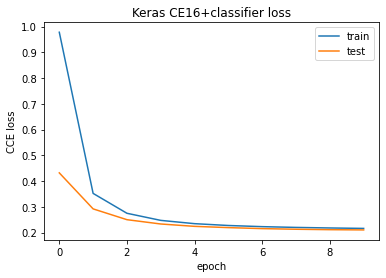

In [3]:
import keras

model = keras.Sequential([
    encoder,
    classifier
])


encoder = model.get_layer('encoder')
encoder.load_weights('../weights/16_CE16_epoch25.h5')
for layer in encoder.layers:
    layer.trainable = False
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# print(model.summary())

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras CE16+classifier loss')
plt.ylabel('CCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

2. TF

In [1]:
import keras
import tensorflow as tf

loss_tracker = keras.metrics.Mean(name='loss')
acc_metric = keras.metrics.CategoricalAccuracy(name='acc')

class tf_model(keras.models.Model):
    def __init__(self):
        super(tf_model, self).__init__()
        self.encoder = encoder
        self.classifier = classifier
        
    def call(self, x):
        z = self.encoder(x)
        y = self.classifier(z)
        return y
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
#             z = self.encoder(x, training=False)
#             y_pred = self.classifier(z, training=True)
            z = self.encoder(x)
            y_pred = self.classifier(z)
            loss = self.compiled_loss(y, y_pred)
        trainable_vars = self.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))
        
        loss_tracker.update_state(loss)
        acc_metric.update_state(y, y_pred)
        return {"loss": loss_tracker.result(), "acc": acc_metric.result()}
    
    @property
    def metrics(self):
        return [loss_tracker, acc_metric]
    
model = tf_model()
model.encoder.load_weights('../weights/16_CE16_epoch25.h5')
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# for layer in model.encoder.layers:
#     layer.trainable = False
    
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('TF CAE16 loss')
plt.ylabel('CCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

NameError: name 'encoder' is not defined